<a href="https://colab.research.google.com/github/v-smith/PK_Document_Classification/blob/main/PKTableClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PK Document Classification with BERT Embeddings and XGBoost

## 1. Load in and prep data

First you need to load in your labelled data and then match these labels with the data which has abstract and other text present.

In [ ]:
# load packages
import os
import pandas as pd
import numpy as np
import seaborn as sns
!pip install wordcloud

In [ ]:
# Mount your Google Drive so you can read in data from there (you need to allow permissions when pop-up comes)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load in labelled data
labelled_df = pd.read_csv('/content/drive/My Drive/PKPDAI_Paper_Classification/pool.csv')

labelled_df = labelled_df[["Pubmed.ID", "Label.By.Reviewer.1..Y.N."]]

labelled_df = labelled_df.rename(columns={"Pubmed.ID": "pmid"})
labelled_df = labelled_df.rename(columns={"Label.By.Reviewer.1..Y.N.": "Final_Label"})
labelled_df.drop_duplicates(subset=["pmid"], keep=False)
print(labelled_df.info())

labelled_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pmid         298 non-null    int64 
 1   Final_Label  298 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.8+ KB
None


,pmid,Final_Label
0,1097636,Y
1,10124,Y
2,883823,Y
3,952693,Y
4,890949,Y


In [ ]:
# load in raw data with text fields
text_df = pd.read_csv('/content/drive/My Drive/PKPDAI_Paper_Classification/allpmids_withmetadata.csv')
text_df = text_df.drop("Unnamed: 0", axis = 1)

In [ ]:
text_df.drop_duplicates(keep=False)
print(text_df.info())
text_df.head()
#print(text_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66815 entries, 0 to 66814
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pmid        66815 non-null  int64 
 1   date        66815 non-null  object
 2   title       66815 non-null  object
 3   authors     66815 non-null  object
 4   journal     66815 non-null  object
 5   abstract    66815 non-null  object
 6   mesh_terms  66815 non-null  object
dtypes: int64(1), object(6)
memory usage: 3.6+ MB
None


,pmid,date,title,authors,journal,abstract,mesh_terms
0,23274625,"{'Year': '2013', 'Month': '06', 'Day': '25'}",Development and validation of an LC-MS/MS meth...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('1873-376X', attributes...",['Tolvaptan is a selective vasopressin V(2)-re...,"[{'QualifierName': [], 'DescriptorName': Strin..."
1,16080280,"{'Year': '2005', 'Month': '08', 'Day': '26'}",Determination of the transdermal bioavailabili...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0004-4172', attributes...",['Two different transdermal diclofenac (CAS 15...,"[{'QualifierName': [], 'DescriptorName': Strin..."
2,30134590,"{'Year': '2018', 'Month': '12', 'Day': '11'}",Bioavailability of Vitamin B<sub>12</sub> from...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('2072-6643', attributes...",['The present study compares the bioavailabili...,"[{'QualifierName': [], 'DescriptorName': Strin..."
3,22071596,"{'Year': '2012', 'Month': '07', 'Day': '27'}",Phase I study of continuous afatinib (BIBW 299...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('1432-0843', attributes...",[StringElement('This Phase I study determined ...,"[{'QualifierName': [], 'DescriptorName': Strin..."
4,22352370,"{'Year': '2012', 'Month': '06', 'Day': '14'}",Pharmacokinetics of 250 μg anti-D IgG in the t...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('1600-0412', attributes...",[StringElement('We present a pharmacokinetic s...,"[{'QualifierName': [], 'DescriptorName': Strin..."


In [ ]:
# combine dataframes to collate fields we want
final_df = pd.merge(labelled_df, text_df, on=["pmid"])
final_df.drop_duplicates(subset=["pmid"], keep=False)
print(final_df.info())
final_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310 entries, 0 to 309
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pmid         310 non-null    int64 
 1   Final_Label  310 non-null    object
 2   date         310 non-null    object
 3   title        310 non-null    object
 4   authors      310 non-null    object
 5   journal      310 non-null    object
 6   abstract     310 non-null    object
 7   mesh_terms   310 non-null    object
dtypes: int64(1), object(7)
memory usage: 21.8+ KB
None


,pmid,Final_Label,date,title,authors,journal,abstract,mesh_terms
0,1097636,Y,"{'Year': '1975', 'Month': '11', 'Day': '06'}","Absorption, distribution, and metabolic fate o...",ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0022-3549', attributes...",['The absorption and metabolic fate of 7-chlor...,"[{'QualifierName': [], 'DescriptorName': Strin..."
1,10124,Y,"{'Year': '1976', 'Month': '12', 'Day': '23'}",Pharmacokinetics of oxprenolol in normal subje...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0009-9236', attributes...",['The effect of oxprenolol administered intrav...,"[{'QualifierName': [], 'DescriptorName': Strin..."
2,883823,Y,"{'Year': '1977', 'Month': '09', 'Day': '17'}",Pharmacokinetics of nafcillin in patients with...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0066-4804', attributes...","['Nafcillin, a pencillinase-resistant penicill...","[{'QualifierName': [], 'DescriptorName': Strin..."
3,952693,Y,"{'Year': '1976', 'Month': '10', 'Day': '29'}",Effects of extradural block: comparison of the...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0007-0912', attributes...","['Five healthy, unmedicated male volunteers, a...",[{'QualifierName': [StringElement('analogs & d...
4,890949,Y,"{'Year': '1977', 'Month': '10', 'Day': '31'}",Relationship between carbamazepine concentrati...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0009-8981', attributes...",['The concentration of carbamazepine in plasma...,"[{'QualifierName': [StringElement('analysis', ..."


In [ ]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
final_df['Final_Label'] = LE.fit_transform(final_df['Final_Label'])
final_df.head()

,pmid,Final_Label,date,title,authors,journal,abstract,mesh_terms
0,1097636,1,"{'Year': '1975', 'Month': '11', 'Day': '06'}","Absorption, distribution, and metabolic fate o...",ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0022-3549', attributes...",['The absorption and metabolic fate of 7-chlor...,"[{'QualifierName': [], 'DescriptorName': Strin..."
1,10124,1,"{'Year': '1976', 'Month': '12', 'Day': '23'}",Pharmacokinetics of oxprenolol in normal subje...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0009-9236', attributes...",['The effect of oxprenolol administered intrav...,"[{'QualifierName': [], 'DescriptorName': Strin..."
2,883823,1,"{'Year': '1977', 'Month': '09', 'Day': '17'}",Pharmacokinetics of nafcillin in patients with...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0066-4804', attributes...","['Nafcillin, a pencillinase-resistant penicill...","[{'QualifierName': [], 'DescriptorName': Strin..."
3,952693,1,"{'Year': '1976', 'Month': '10', 'Day': '29'}",Effects of extradural block: comparison of the...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0007-0912', attributes...","['Five healthy, unmedicated male volunteers, a...",[{'QualifierName': [StringElement('analogs & d...
4,890949,1,"{'Year': '1977', 'Month': '10', 'Day': '31'}",Relationship between carbamazepine concentrati...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0009-8981', attributes...",['The concentration of carbamazepine in plasma...,"[{'QualifierName': [StringElement('analysis', ..."


In [ ]:
final_df["abstract"] = final_df['abstract'].apply(lambda x: str(x).replace('[','').replace(']',''))
final_df.head()

,pmid,Final_Label,date,title,authors,journal,abstract,mesh_terms
0,1097636,1,"{'Year': '1975', 'Month': '11', 'Day': '06'}","Absorption, distribution, and metabolic fate o...",ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0022-3549', attributes...",'The absorption and metabolic fate of 7-chloro...,"[{'QualifierName': [], 'DescriptorName': Strin..."
1,10124,1,"{'Year': '1976', 'Month': '12', 'Day': '23'}",Pharmacokinetics of oxprenolol in normal subje...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0009-9236', attributes...",'The effect of oxprenolol administered intrave...,"[{'QualifierName': [], 'DescriptorName': Strin..."
2,883823,1,"{'Year': '1977', 'Month': '09', 'Day': '17'}",Pharmacokinetics of nafcillin in patients with...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0066-4804', attributes...","'Nafcillin, a pencillinase-resistant penicilli...","[{'QualifierName': [], 'DescriptorName': Strin..."
3,952693,1,"{'Year': '1976', 'Month': '10', 'Day': '29'}",Effects of extradural block: comparison of the...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0007-0912', attributes...","'Five healthy, unmedicated male volunteers, ag...",[{'QualifierName': [StringElement('analogs & d...
4,890949,1,"{'Year': '1977', 'Month': '10', 'Day': '31'}",Relationship between carbamazepine concentrati...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0009-8981', attributes...",'The concentration of carbamazepine in plasma ...,"[{'QualifierName': [StringElement('analysis', ..."


In [ ]:
final_df["abstract_and_title"] = final_df["title"] + final_df["abstract"]
final_df.head()

,pmid,Final_Label,date,title,authors,journal,abstract,mesh_terms,abstract_and_title
0,1097636,1,"{'Year': '1975', 'Month': '11', 'Day': '06'}","Absorption, distribution, and metabolic fate o...",ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0022-3549', attributes...",'The absorption and metabolic fate of 7-chloro...,"[{'QualifierName': [], 'DescriptorName': Strin...","Absorption, distribution, and metabolic fate o..."
1,10124,1,"{'Year': '1976', 'Month': '12', 'Day': '23'}",Pharmacokinetics of oxprenolol in normal subje...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0009-9236', attributes...",'The effect of oxprenolol administered intrave...,"[{'QualifierName': [], 'DescriptorName': Strin...",Pharmacokinetics of oxprenolol in normal subje...
2,883823,1,"{'Year': '1977', 'Month': '09', 'Day': '17'}",Pharmacokinetics of nafcillin in patients with...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0066-4804', attributes...","'Nafcillin, a pencillinase-resistant penicilli...","[{'QualifierName': [], 'DescriptorName': Strin...",Pharmacokinetics of nafcillin in patients with...
3,952693,1,"{'Year': '1976', 'Month': '10', 'Day': '29'}",Effects of extradural block: comparison of the...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0007-0912', attributes...","'Five healthy, unmedicated male volunteers, ag...",[{'QualifierName': [StringElement('analogs & d...,Effects of extradural block: comparison of the...
4,890949,1,"{'Year': '1977', 'Month': '10', 'Day': '31'}",Relationship between carbamazepine concentrati...,ListElement([DictElement({'AffiliationInfo': [...,"{'ISSN': StringElement('0009-8981', attributes...",'The concentration of carbamazepine in plasma ...,"[{'QualifierName': [StringElement('analysis', ...",Relationship between carbamazepine concentrati...


Maybe do some visualisations of this final dataframe - count plots or wordcounts to get some idea about the dataset, could be good for your project

<Axes: xlabel='Final_Label', ylabel='count'>

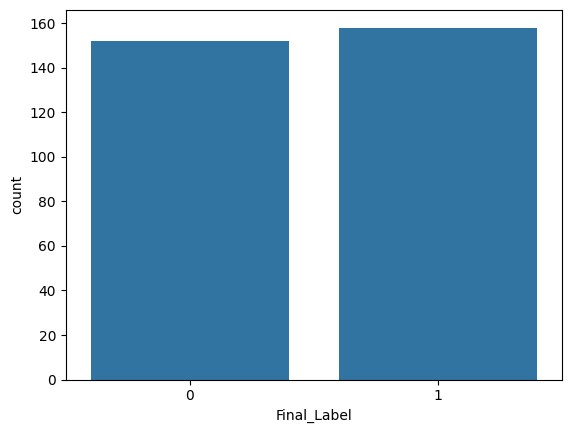

In [ ]:
# my plots
sns.countplot(data = final_df, x = 'Final_Label')

# published year plot

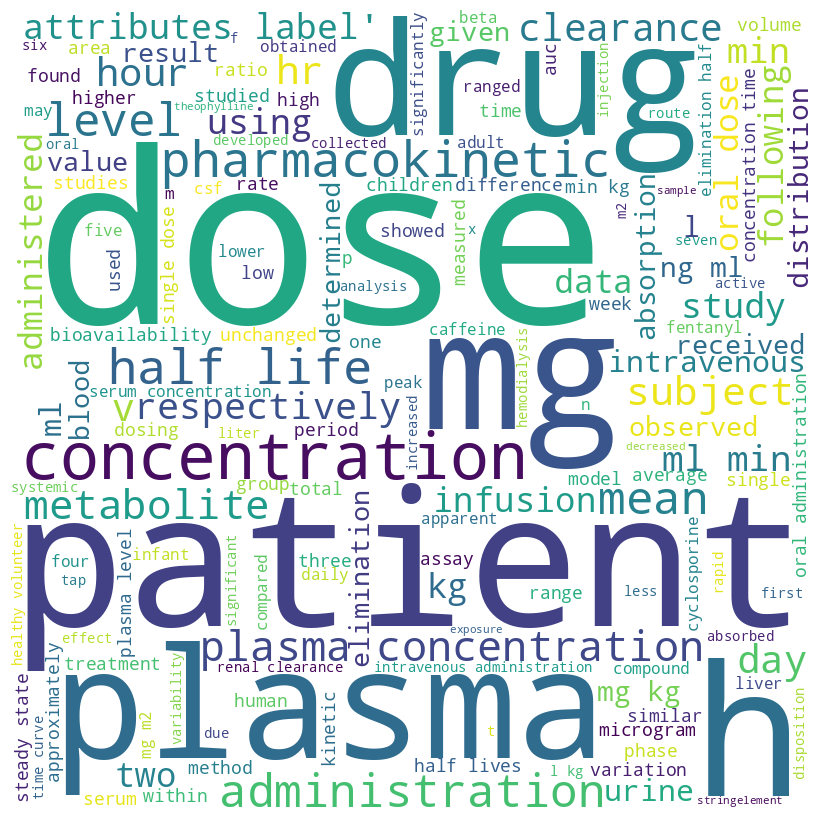

In [ ]:
# below I've done an example wordcloud for the title, maybe interesting to compare between different sections or between positive and negative label, can also play around with using only top n words

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

filtered_df = final_df[final_df['Final_Label'] == 1]

words = ""
for val in filtered_df.abstract:
    # each val to string
    val = str(val)
    # split the value
    tokens = val.split()
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(words)


plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


## Split Data into Train/Test Fields

In [ ]:
from sklearn.model_selection import train_test_split

#maybe try stratified sampling for train,test,val - so that the % of y and n labels will be the same in each category
#removing some N labels from the datatset

def split_stratified_into_train_val_test(df_input, stratify_colname='Final_Label',
                                         frac_train=0.6, frac_val=0.2, frac_test=0.2,
                                         random_state=None):
    '''
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in final_df.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = final_df # Contains all columns.
    y = final_df[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

In [ ]:
train, val, test = split_stratified_into_train_val_test(final_df, stratify_colname='Final_Label',
                                         frac_train=0.6, frac_val=0.2, frac_test=0.2,
                                         random_state=None)

In [ ]:
print(train.info())
print(val.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186 entries, 130 to 40
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   pmid                186 non-null    int64 
 1   Final_Label         186 non-null    int64 
 2   date                186 non-null    object
 3   title               186 non-null    object
 4   authors             186 non-null    object
 5   journal             186 non-null    object
 6   abstract            186 non-null    object
 7   mesh_terms          186 non-null    object
 8   abstract_and_title  186 non-null    object
dtypes: int64(2), object(7)
memory usage: 14.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 159 to 252
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   pmid                62 non-null     int64 
 1   Final_Label         62 non-null     int64 
 2   date     

In [ ]:
train.to_csv('/content/drive/My Drive/train_data.csv', index=False)
test.to_csv('/content/drive/My Drive/test_data.csv', index=False)
val.to_csv('/content/drive/My Drive/validation_data.csv', index=False)

## Use a simple method, TF-IDF, as a baseline

In [ ]:
# X is text and y is labels
# lets iterate through table fields and print results
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,  TfidfTransformer
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score


fields_to_try = ["abstract_and_title", 'title', 'abstract','authors','date', 'journal',  'mesh_terms']

for field in fields_to_try:
    print(f"--------------------------")
    print(f"Training XGBoost on {field}")
    X_train = train[field]
    y_train = train["Final_Label"]
    unique, counts = np.unique(y_train, return_counts=True)
    weight = counts[0]/counts[1]

    X_val = val[field]
    y_val = val["Final_Label"]

    X_test = test[field]
    y_test = test["Final_Label"]

    pipe = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('model', xgb.XGBClassifier(
                  eta= 0.3, # lr
                  gamma = 0, # min split loss (larger gamma means more conservative algorithm)
                  max_depth= 6, # max depth of tree - larger value will make the model more complex and more likley to overfit
                  min_child_weight=1, #good for imbalanced class problem as leaf nodes can have smaller size groups
                  subsample = 0.5, # 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees, prevent overfitting
                  scale_pos_weight = weight,  # sum(negative instances) / sum(positive instances)
                  use_label_encoder=True,
                  eval_metric='auc'))
                ])

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_val)
    y_pred_train = pipe.predict(X_train)

    print('Train: {}'.format(f1_score(y_train, y_pred_train)))
    print(f'Precision For Test Data: -> {round(precision_score(y_val, y_pred),2)}')
    print(f'Recall For Test Data: -> {round(recall_score(y_val, y_pred),2)}')
    print(f'F1 Score For Test Data: -> {round(f1_score(y_val, y_pred),2)}')
    print(f'Confusion Matrix Score For Test Data:\n {confusion_matrix(y_val, y_pred)}')

    # LOW recall! Missing lots


--------------------------
Training XGBoost on abstract_and_title
Train: 1.0
Precision For Test Data: -> 0.47
Recall For Test Data: -> 0.45
F1 Score For Test Data: -> 0.46
Confusion Matrix Score For Test Data:
 [[15 16]
 [17 14]]
--------------------------
Training XGBoost on title
Train: 0.9893617021276596
Precision For Test Data: -> 0.6
Recall For Test Data: -> 0.58
F1 Score For Test Data: -> 0.59
Confusion Matrix Score For Test Data:
 [[19 12]
 [13 18]]
--------------------------
Training XGBoost on abstract
Train: 1.0
Precision For Test Data: -> 0.47
Recall For Test Data: -> 0.45
F1 Score For Test Data: -> 0.46
Confusion Matrix Score For Test Data:
 [[15 16]
 [17 14]]
--------------------------
Training XGBoost on authors
Train: 0.983957219251337
Precision For Test Data: -> 0.47
Recall For Test Data: -> 0.45
F1 Score For Test Data: -> 0.46
Confusion Matrix Score For Test Data:
 [[15 16]
 [17 14]]
--------------------------
Training XGBoost on date
Train: 0.968421052631579
Precision

In [ ]:
  X_train = train["title"]
  y_train = train["Final_Label"]

  X_val = val["title"]
  y_val = val["Final_Label"]

  X_test = test["title"]
  y_test = test["Final_Label"]

## Resampling and SMOTE for imbalanced data

In [ ]:
!pip install imbalanced-learn

In [ ]:
# lets try undersampling
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.under_sampling import RandomUnderSampler

model = make_pipeline_imb(TfidfVectorizer(), RandomUnderSampler(replacement=True,random_state=12,), xgb.XGBClassifier(learning_rate=0.1, max_depth=7,n_estimators=80,use_label_encoder=False,eval_metric='aucpr'))

model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f'Precision For Test Data: -> {round(precision_score(y_val, y_pred),2)}')
print(f'Recall For Test Data: -> {round(recall_score(y_val, y_pred),2)}')
print(f'F1 Score For Test Data: -> {round(f1_score(y_val, y_pred),2)}')
print(f'Confusion Matrix Score For Test Data:\n {confusion_matrix(y_val, y_pred)}')

# NOTE this increases the recall but drops the precision -> we are getting more wrong with this

# Oversampling
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import RandomOverSampler

model = make_pipeline_imb(TfidfVectorizer(), RandomOverSampler(random_state=12), xgb.XGBClassifier(learning_rate=0.1, max_depth=7,n_estimators=80,use_label_encoder=False,eval_metric='aucpr'))

model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f'Precision For Test Data: -> {round(precision_score(y_val, y_pred),2)}')
print(f'Recall For Test Data: -> {round(recall_score(y_val, y_pred),2)}')
print(f'F1 Score For Test Data: -> {round(f1_score(y_val, y_pred),2)}')
print(f'Confusion Matrix Score For Test Data:\n {confusion_matrix(y_val, y_pred)}')

# SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB

model = Pipeline([
  ('tfidf', TfidfVectorizer()),
  ('smote', SMOTE(random_state=12)),
  ('xgb', xgb.XGBClassifier(learning_rate=0.1, max_depth=7,n_estimators=80,use_label_encoder=False,eval_metric='aucpr'))])


model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f'Precision For Test Data: -> {round(precision_score(y_val, y_pred),2)}')
print(f'Recall For Test Data: -> {round(recall_score(y_val, y_pred),2)}')
print(f'F1 Score For Test Data: -> {round(f1_score(y_val, y_pred),2)}')
print(f'Confusion Matrix Score For Test Data:\n {confusion_matrix(y_val, y_pred)}')

Precision For Test Data: -> 0.62
Recall For Test Data: -> 0.48
F1 Score For Test Data: -> 0.55
Confusion Matrix Score For Test Data:
 [[22  9]
 [16 15]]
Precision For Test Data: -> 0.61
Recall For Test Data: -> 0.55
F1 Score For Test Data: -> 0.58
Confusion Matrix Score For Test Data:
 [[20 11]
 [14 17]]
Precision For Test Data: -> 0.56
Recall For Test Data: -> 0.58
F1 Score For Test Data: -> 0.57
Confusion Matrix Score For Test Data:
 [[17 14]
 [13 18]]


Overall, resampling techniques did not prove very useful. XGBoost is anyway mean to be good with dealing with imbalanced data, especially as we weighted it proportional to the class frequencies.

## Use Pre-trained LLMs to generate Sentence Embeddings

The example below is again using just the title - you can try using different text fields from the papers or combining text fields (can just concatenate these together into one long string). When you use mutliple paper fields we might find that the input is too long as input to BERT which has a maximum input of 512 tokens.

In [ ]:
# load in packages
import torch
!pip install transformers
from transformers import AutoTokenizer, AutoModel
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
# get embeddings

# example using the title only

# NB that here is where you change model name so for example can use bioBERT here
# start with BERT -> bert-base-uncased
# try bioBERT -> dmis-lab/biobert-v1.1
# try pubmedBERT -> microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1", output_hidden_states=True).to(device)
model.eval()

tokenized_train = tokenizer(X_train.to_list(), padding = True, truncation = True, return_tensors="pt")
tokenized_val = tokenizer(X_val.to_list() , padding = True, truncation = True,  return_tensors="pt")

print(tokenized_train.keys())
print(tokenized_train["input_ids"][0])
print(len(tokenized_train["input_ids"]))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}

<ipython-input-26-e79299fa1e05>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
with torch.no_grad():
  hidden_val = model(**tokenized_val)
  hidden_train = model(**tokenized_train)

print(hidden_train.last_hidden_state.shape)
print(hidden_val.last_hidden_state.shape)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
#get only the [CLS] hidden states (represents the whole sequence with one token)
cls_train = hidden_train.last_hidden_state[:,0,:]
cls_val = hidden_val.last_hidden_state[:,0,:]

You can change the hyperparameters of xgboost -> have a look at this article https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
Try playing around with different depths, learning rates etc.

You can also use a method called Grid Search to look for good hyperparameter combinations - please see the following:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost

In [ ]:
# train xgboost

x_train = cls_train.to("cpu")
y_train = train["Final_Label"]

x_val = cls_val.to("cpu")
y_val = val["Final_Label"]

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

clf = xgb.XGBClassifier(eta= 0.1, # lr
                        gamma = 0, # min split loss (larger gamma means more conservative algorithm)
                        max_depth= 6, # max depth of tree - larger value will make the model more complex and more likley to overfit
                        min_child_weight=4, #good for imbalanced class problem as leaf nodes can have smaller size groups
                        subsample = 0.8, # 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees, prevent overfitting
                        #scale_pos_weight = weight,  # sum(negative instances) / sum(positive instances)
                        use_label_encoder=True,
                        eval_metric='auc')

clf.fit(x_train, y_train)

torch.Size([186, 768]) (186,) torch.Size([62, 768]) (62,)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='auc',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

Please feel free to add anything here to the evaluation - you can check out different Machine Learning evaluation metrics and most can be implemented with sklearn metrics => https://scikit-learn.org/stable/modules/model_evaluation.html

In [ ]:
y_pred = clf.predict(x_val)
# y_pred_train = pipe.predict(X_train)

# print('Train: {}'.format(f1_score(y_train, y_pred_train)))
print(f'F1 Score For Test Data: -> {round(f1_score(y_val, y_pred),2)}')
print(f'Confusion Matrix Score For Test Data:\n {confusion_matrix(y_val, y_pred)}')

F1 Score For Test Data: -> 0.69
Confusion Matrix Score For Test Data:
 [[18 13]
 [ 8 23]]


## Evaluate Final Pipeline on the test set

Again as above, please feel free to add anything here to the evaluation - you can check out different Machine Learning evaluation metrics and most can be implemented with sklearn metrics => https://scikit-learn.org/stable/modules/model_evaluation.html

In [ ]:
tokenized_test = tokenizer(X_test.to_list() , padding = True, truncation = True,  return_tensors="pt")
tokenized_test = {k:torch.tensor(v).to(device) for k,v in tokenized_test.items()}
with torch.no_grad():
  hidden_test = model(**tokenized_test)
cls_test = hidden_test.last_hidden_state[:,0,:]
x_test = cls_test.to("cpu")
y_test = test["Final_Label"]

y_test_pred = clf.predict(x_test)
print(f'F1 Score For Test Data: -> {round(f1_score(y_test, y_test_pred),2)}')
print(f'Confusion Matrix Score For Test Data:\n {confusion_matrix(y_test, y_test_pred)}')

<ipython-input-32-8428a952c633>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_test = {k:torch.tensor(v).to(device) for k,v in tokenized_test.items()}


F1 Score For Test Data: -> 0.66
Confusion Matrix Score For Test Data:
 [[19 11]
 [11 21]]
